# Lab 7: Predicting Social Mobility using Cross Validation and Random Forests

## Methods/concepts: loops, steady states, random forests, cross validation

**Name:** Shreya Chaturvedi

**Email:** shreyachaturvedi@hks.harvard.edu

**HUID:** 31575036

**Lab:** Thursday 3pm at HKS

**Date:** April 4th, 2024

**LAB DESCRIPTION**

This is the second lab on prediction policy questions. In this lab, you
will predict upward mobility using *decision trees* and *random
forests*. The measure of upward mobility that we will focus on is
**Statistic 1: Absolute Mobility at the 25th Percentile** in each county
(**kfr_pooled_pooled_p25**). For more details on the variables
included in these data, see [Table 1](#Table1).

The “training” dataset is a 50% random sample of all counties with at
least 10,000 residents available from the Opportunity Atlas. You will
use 121 community characteristics to predict the variable
**kfr_pooled_pooled_p25**. The other half of these data has been set
aside as a “lock box” data set that you will use to evaluate your
models. The training data set contains predictors for both the test and
training sets to avoid data snooping, but only outcomes for the training
set. The lock box data set contains only the outcomes for the test set.

In the R labs, we will start from starter scripts that can either be run
on your computer or the Ec 50 Jupyter Hub.

## **QUESTIONS**

1.  Primer on for loops in the context of steady states. We will start
    with a review of the calculation from the Lecture where Professor
    Chetty introduced the concept of a steady state (Becker and Tomes
    1979). This review will also give us an opportunity to walk through
    loops step by step. Chetty et al. (2020) report the following
    rank-rank regression pooling all races and genders:

    $$\text{Rank}_{\text{kids}} = 33.31\  + \ 0.351\text{Rank}_{\text{parents}}$$

    Using the sample code, show that this model predicts convergence in incomes across racial groups. This result is unrealistic because racial disparities have persisted for many generations in the U.S. However, the model is incorrect: we know from Lab 2 and Lecture that children of different races experience very different rates of upward mobility across generations. In particular, Chetty et al. (2020) report the following rank-rank regression for Black children:

    $$\text{Rank}_{\text{kids}} = 25.4\  + \ 0.28\text{Rank}_{\text{parents}}$$

    and for Hispanic children:

    $$\text{Rank}_{\text{kids}} = 36.14\  + \ 0.26\text{Rank}_{\text{parents}}$$

    Use a for loop to find the **steady state prediction** of the model for Black and Hispanic children.

In [1]:
#  The following program starts with a primer on loops in the context of steady 
#  states.  You'll modify the example loop to study how differences in intergen-
#  erational mobility by race and ethnicity affects inequality in the long run.
#  
#  The next part of the program shows how to implement cross validation and 
#  random forests using data from the Opportunity Atlas.  The example code illustrates
#  10-fold cross validation.  You have to modify the code to instead implement 5 fold
#  cross validation.  You also have to choose your own predictors. After running the 
#  loop for cross validation, the example code shows how to plot the cross validation
#  RMSPE as a function of the tree depth.
#  
#  The next step is to use the cross validation graph to choose the optimal tree depth
#  and implement a decision tree with that chosen depth.  
#
#  Then the code illustrates how to estimate two random forests (one with 
#  hand picked predictors and the other using all the predictors), generate
#  predictions, and make variable importance plot for the large random forest.
#
#  The last part of the code calculates the RMSPE for the three models using
#  the training data (atlas_training.dta) and the "lock box data" (atlas_lockbox.dta)
#
#  The code may have some typos -- please be on the look out for them -- and to 
#  receive credit for the lab you have to make edits to estimate your own 
#  decision tree and random forests.  These are simply examples of what you might
#  what to  do in your analysis, but you are expected to make an effort to 
#  understand what you are doing with the code.
#
#  Inputs:  atlas_training.dta and atlas_lockbox.dta (download from canvas)
#           randomForest to estimate random forest models
#           rpart library to estimate decision trees
#           tidyverse library for data manipulations
#           haven library to load stata data sets into R
#
#  Outputs: figure1.png, figure2.png, figure3.png 

# Question 1 example code
rm(list=ls()) # removes all objects from the environment 

# Install packages (if necessary) and load required libraries
if (!require(haven)) install.packages("haven"); library(haven)
if (!require(randomForest)) install.packages("randomForest"); library(randomForest)
if (!require(rpart)) install.packages("rpart"); library(rpart)
if (!require(tidyverse)) install.packages("tidyverse"); library(tidyverse)

#Set seed for cross validation and random forests
HUID <- 50505050 #Replace with your HUID
set.seed(HUID)

#-------------------------------------------------------------------------------
# Primer on loops in the context of steady states
#-------------------------------------------------------------------------------

# Chetty et al. (2020) report the following rank-rank regression pooling all 
# races and genders: Rank_{kids} =  33.31 + 0.351 *  Rank_{parents}
# 
# The average income rank for white parents today is the $57.9$th percentile. 
# We predict that the average white child will reach the following percentile 
# when they are adults:

parents_rank <- 57.9
kids_rank <- 33.31 + 0.351 * parents_rank
kids_rank

# For the next generation, the predicted rank for the (average) white grandchild
# is:

parents_rank = kids_rank
kids_rank = 33.31 + 0.351 * parents_rank
kids_rank

# Now we may want to study the predictions from this model across many 
# generations: the grandchilden, the great grandchildren, and the 
# great great grand children, and so on.  We can do this using a loop

generations <- seq(1,7,1) #This is for generations 1 through 7

parents_rank = 57.9 #This is the starting value for the parent's generation

# use a for loop to run the experiment
for(j in generations){ 
  #Calculate kid's predicted rank
  kids_rank <- 33.31 + 0.351 * parents_rank
  
  #Print the output to the console
  print(paste0("In generation ", j, ", parent_rank = ", parents_rank, ", child_rank = ", kids_rank))
  
  #Set parent's rank equal to kids' rank so we are ready for the next iteration
  parents_rank <- kids_rank
}

# Notice that the model predicts that the average white child will reach the
# 51.3rd percentile in generation 7, which is lower than where the first 
# generation started from (which you will recall was the $57.9$th percentile).  
# This is a reduction of around 6 percentiles.
# 
# Meanwhile, the average income rank for Black parents is the 32.7th percentile.
# If we apply the same rank-rank relationship between Black parents and Black 
# children that we did above, our model predicts that the average Black child 
# will reach the 44.9th percentile when they grow up, with further gains for 
# future generations.

generations <- seq(1,7,1) #This is for generations 1 through 7
parents_rank = 32.7 #This is the starting value for the parent's generation
for(j in generations){ 
  kids_rank <- 33.31 + 0.351 * parents_rank
  print(paste0("In generation ", j, ", parent_rank = ", parents_rank, ", child_rank = ", kids_rank))
  parents_rank <- kids_rank
}

# As you can see, this model predicts substantial improvements in outcomes for
# Black children across generations, with average gains of 12 percentiles in a 
# single generation.  The model makes the unrealistic prediction of convergence
# in outcomes across racial groups: By generation 7, both white and Black children
# are at the 51.3 percentile.  This result is unrealistic because racial disparities 
# have persisted for many generations in the United States.
# 
# However, the model is incorrect: we know from Lab 2 and Lecture that Black 
# children and white children experience very different rates of upward mobility 
# across generations. In particular, Chetty et al. (2020) report the following 
# rank-rank regression for Black children:
# 
# Rank_{kids} =  25.4 + 0.28 *  Rank_{parents}
# 
# The prediction implied by this rank-rank graph is very different than the 
# previous calculations suggested.  To see this, in the first generation this 
# model predicts:

parents_rank = 32.7
kids_rank = 25.4 + 0.28 * parents_rank
kids_rank

# In stark contrast to the predictions from the calculations earlier, here 
# there is hardly any predicted improvement in the income rank for Black children
# in generation 1.  To see what happens across generations, we can update our 
# loop:

generations <- seq(1,7,1) #This is for generations 1 through 7
parents_rank = 32.7 #This is the starting value for the parent's generation
for(j in generations){ 
  kids_rank = 25.4 + 0.28 * parents_rank
  print(paste0("In generation ", j, ", parent_rank = ", parents_rank, ", child_rank = ", kids_rank))
  parents_rank <- kids_rank
}

Loading required package: haven

Loading required package: randomForest

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Loading required package: rpart

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine()  masks randomForest::combine()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ ggplot2::margin() masks randomForest::margin()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] 53.6329

[1] 52.13515

[1] "In generation 1, parent_rank = 57.9, child_rank = 53.6329"
[1] "In generation 2, parent_rank = 53.6329, child_rank = 52.1351479"
[1] "In generation 3, parent_rank = 52.1351479, child_rank = 51.6094369129"
[1] "In generation 4, parent_rank = 51.6094369129, child_rank = 51.4249123564279"
[1] "In generation 5, parent_rank = 51.4249123564279, child_rank = 51.3601442371062"
[1] "In generation 6, parent_rank = 51.3601442371062, child_rank = 51.3374106272243"
[1] "In generation 7, parent_rank = 51.3374106272243, child_rank = 51.3294311301557"
[1] "In generation 1, parent_rank = 32.7, child_rank = 44.7877"
[1] "In generation 2, parent_rank = 44.7877, child_rank = 49.0304827"
[1] "In generation 3, parent_rank = 49.0304827, child_rank = 50.5196994277"
[1] "In generation 4, parent_rank = 50.5196994277, child_rank = 51.0424144991227"
[1] "In generation 5, parent_rank = 51.0424144991227, child_rank = 51.2258874891921"
[1] "In generation 6, parent_rank = 51.2258874891921, child_rank = 51.290286

[1] 34.556

[1] "In generation 1, parent_rank = 32.7, child_rank = 34.556"
[1] "In generation 2, parent_rank = 34.556, child_rank = 35.07568"
[1] "In generation 3, parent_rank = 35.07568, child_rank = 35.2211904"
[1] "In generation 4, parent_rank = 35.2211904, child_rank = 35.261933312"
[1] "In generation 5, parent_rank = 35.261933312, child_rank = 35.27334132736"
[1] "In generation 6, parent_rank = 35.27334132736, child_rank = 35.2765355716608"
[1] "In generation 7, parent_rank = 35.2765355716608, child_rank = 35.277429960065"


In [2]:
# As you can see, the income rank hardly improves at all for the second and 
# third generation, and eventually stabilizes after four generations at the 
# 35.3rd percentile. The 35.3rd percentile is the steady state (or fixed point)
# prediction for Black children, because the model predicts no further 
# improvement once average income reaches this level. 
# 
# In contrast, similar calculations would show that the 54.2nd percentile 
# is the steady state (or fixed point) of the model for white children. 
# These stark steady state gaps show that addressing racial disparities in 
# upward mobility is crucial for lessening racial disparities in the United States. 
# 
# ## Trying it on your own
# 
# Chetty, Hendren, Jones, and Porter (2020) report the following estimates 
# for Hispanic children: 
# 
# Rank_{kids} =  36.14 + 0.26 *  Rank_{parents}
# 
# The average income rank for Hispanic parents is the 36.17th percentile.  
#
# Write your own for loop to study the predictions from the model for Hispanic 
# children over the next 7 generations.
#
# Using the output from your for loop, what is the steady state prediction for 
# Hispanic children?

## YOUR QUESTION 1 CODE GOES HERE
parents_rank = 36.14 #This is the starting value for the parent's generation
for(j in generations){ 
  kids_rank = 36.14 + 0.26 * parents_rank
  print(paste0("In generation ", j, ", parent_rank = ", parents_rank, ", child_rank = ", kids_rank))
  parents_rank <- kids_rank
}

[1] "In generation 1, parent_rank = 36.14, child_rank = 45.5364"
[1] "In generation 2, parent_rank = 45.5364, child_rank = 47.979464"
[1] "In generation 3, parent_rank = 47.979464, child_rank = 48.61466064"
[1] "In generation 4, parent_rank = 48.61466064, child_rank = 48.7798117664"
[1] "In generation 5, parent_rank = 48.7798117664, child_rank = 48.822751059264"
[1] "In generation 6, parent_rank = 48.822751059264, child_rank = 48.8339152754086"
[1] "In generation 7, parent_rank = 48.8339152754086, child_rank = 48.8368179716063"


**Question 1 Answer**

From this loop, we can see that the steady state prediction for Hispanic children is 48.8 percentile rank as this is the approximate value that the rank converges to after the 4th or 5th iteration of the loop. 

2.  Explain briefly how cross-validation helps us avoid the overfit
    problem.

In [3]:
# QUESTION 2 Code


**Question 2 Answer**

Cross-validation is a statistical method used to evaluate the generalizability of a model by dividing the data into multiple parts, training the model on some parts and validating it on the others. This process helps in avoiding the overfitting problem by ensuring that the model performs well not just on the data it was trained on, but also on unseen data. By repeatedly training and testing the model on different subsets of data, cross-validation provides a more accurate measure of a model's predictive power and robustness, reducing the risk of it capturing noise as if it were a true pattern.

3.  Modify the example code to implement **five-fold cross validation**
    to choose the depth of a decision tree that uses just two
    predictors. It is your choice of which two predictors, but they
    should not be the same as my two! Pick your own! The predictors are
    the variables P_1 through P_121 in the data, but their real names
    are included in the data dictionary available in [Table 3](#Table3)
    below.

    1. Plot the cross-validation pseudo out-of-sample root mean squared
        prediction error (CV RMSE) versus the depth of the tree.
    2. Using the graph that you produced, what tree depth is optimal?
    3.  Now use the full training data set to estimate a tree of the
        depth you selected in the previous question. Visualize the tree.
        Which predictors are being used in the first several splits of
        the tree?
    4. Obtain predictions in the training sample.

In [4]:
#-------------------------------------------------------------------------------
# Data set up
#-------------------------------------------------------------------------------

#Open stata data set
download.file("https://raw.githubusercontent.com/ekassos/ec50_s24/main/atlas_training.dta", "atlas_training.dta", mode = "wb")
atlas_training <- read_dta("atlas_training.dta")
head(atlas_training)

#Store predictor variables which all start with P_*
vars <- colnames(atlas_training[,grep("^[P_]", names(atlas_training))])

vars

#Create a training data frame with just predictors P_* and kfr_pooled_pooled_p25
training <- subset(atlas_training, training==1, vars)
training$kfr_pooled_pooled_p25 <- atlas_training[atlas_training$training==1,]$kfr_pooled_pooled_p25

geoid,place,pop,housing,kfr_pooled_pooled_p25,test,training,P_1,P_2,P_3,⋯,P_112,P_113,P_114,P_115,P_116,P_117,P_118,P_119,P_120,P_121
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1003,Baldwin County,187114,104061,38.88471,0,1,82.84795,98.59345,101.77671,⋯,0,19.10,0.00,2.01,0.00,3.52,0,0.00,0,0
1005,Barbour County,27321,11829,34.93856,0,1,76.31390,93.87872,90.70294,⋯,0,45.16,0.00,4.84,0.00,1.61,0,3.23,0,0
1007,Bibb County,22754,8981,36.33907,0,1,73.76562,104.86847,82.12955,⋯,0,30.91,0.00,7.27,0.00,1.82,0,0.00,0,0
1013,Butler County,20624,9964,35.72486,0,1,92.09667,121.07330,117.82320,⋯,0,41.07,0.00,5.36,0.00,1.79,0,0.00,0,0
1015,Calhoun County,117714,53289,36.18467,0,1,76.93821,95.47825,98.32662,⋯,0,18.79,0.61,3.03,0.61,2.42,0,0.00,0,0
1017,Chambers County,34145,17004,34.05749,0,1,136.60245,153.13280,138.80225,⋯,0,32.53,0.00,3.61,0.00,4.82,0,0.00,0,0


[1] "P_1"   "P_2"   "P_3"   "P_4"   "P_5"   "P_6"   "P_7"   "P_8"   "P_9"  
 [10] "P_10"  "P_11"  "P_12"  "P_13"  "P_14"  "P_15"  "P_16"  "P_17"  "P_18" 
 [19] "P_19"  "P_20"  "P_21"  "P_22"  "P_23"  "P_24"  "P_25"  "P_26"  "P_27" 
 [28] "P_28"  "P_29"  "P_30"  "P_31"  "P_32"  "P_33"  "P_34"  "P_35"  "P_36" 
 [37] "P_37"  "P_38"  "P_39"  "P_40"  "P_41"  "P_42"  "P_43"  "P_44"  "P_45" 
 [46] "P_46"  "P_47"  "P_48"  "P_49"  "P_50"  "P_51"  "P_52"  "P_53"  "P_54" 
 [55] "P_55"  "P_56"  "P_57"  "P_58"  "P_59"  "P_60"  "P_61"  "P_62"  "P_63" 
 [64] "P_64"  "P_65"  "P_66"  "P_67"  "P_68"  "P_69"  "P_70"  "P_71"  "P_72" 
 [73] "P_73"  "P_74"  "P_75"  "P_76"  "P_77"  "P_78"  "P_79"  "P_80"  "P_81" 
 [82] "P_82"  "P_83"  "P_84"  "P_85"  "P_86"  "P_87"  "P_88"  "P_89"  "P_90" 
 [91] "P_91"  "P_92"  "P_93"  "P_94"  "P_95"  "P_96"  "P_97"  "P_98"  "P_99" 
[100] "P_100" "P_101" "P_102" "P_103" "P_104" "P_105" "P_106" "P_107" "P_108"
[109] "P_109" "P_110" "P_111" "P_112" "P_113" "P_114" "P_115" "P_116" "P_117"
[118] "P_118" "P_119" "P_120" "P_121"

fold,squarederror,maxdepth
<int>,<dbl>,<dbl>
1,5624.321,1
2,5274.516,1
3,6071.866,1
4,5211.319,1
5,4687.461,1
1,5296.612,2
2,4679.135,2
3,5198.713,2
4,4865.258,2


      fold    squarederror     maxdepth    
 Min.   :1   Min.   :4183   Min.   : 1.00  
 1st Qu.:2   1st Qu.:4645   1st Qu.: 5.75  
 Median :3   Median :5047   Median :10.50  
 Mean   :3   Mean   :4973   Mean   :10.50  
 3rd Qu.:4   3rd Qu.:5150   3rd Qu.:15.25  
 Max.   :5   Max.   :6072   Max.   :20.00  

,ssr,maxdepth
,<dbl>,<dbl>
1,26869.48,1
2,24884.58,2
3,23443.21,3
4,22576.58,4
5,23421.31,5
6,23622.33,6
7,24062.95,7
8,24750.76,8
9,25020.36,9


Saving 6.67 x 6.67 in image


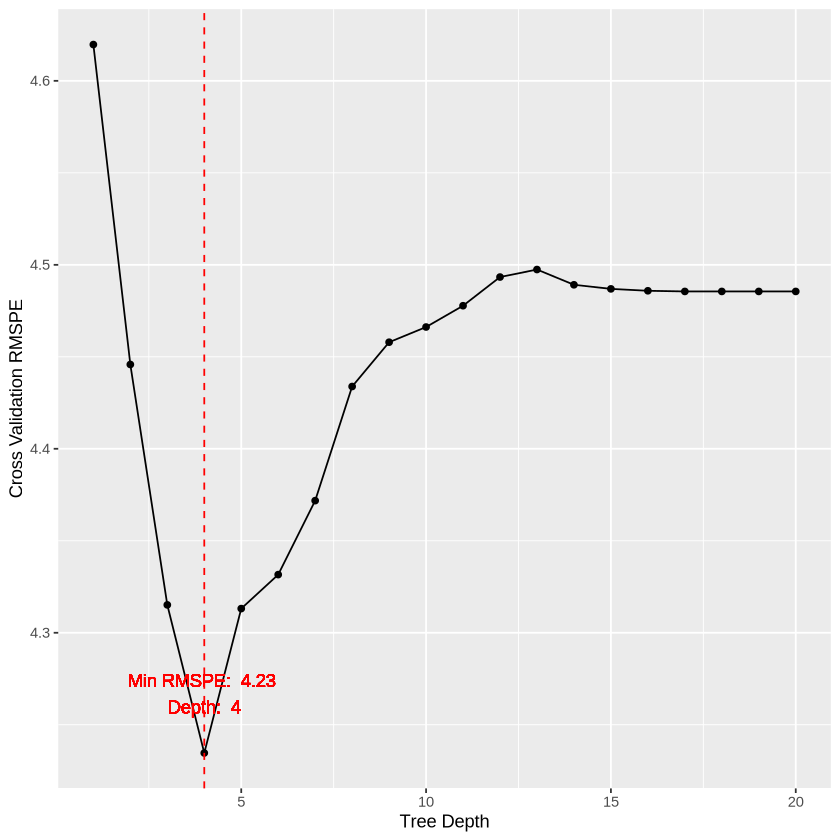

In [5]:
# Question 3a example code

#-------------------------------------------------------------------------------
# Decision tree with cross validation and two hand picked predictors
#-------------------------------------------------------------------------------

# Implement five-fold cross validation to choose the depth of a decision tree 
# that uses two of the predictors (your choice which predictors). Plot the 
# cross-validation out of sample root mean squared prediction error (CV RMSE) 
# versus the depth of the tree.

# Modify the code to change from 10 fold cross validation to 5
# and change the predictors that I use to two others 
# (Don't use my predictors! Pick your own!)

##Illustrate cross validation##
#K-fold Cross validation to select tree depth
# First we need to set a few objects that will be used in the loop below
n <- nrow(training) # the number of observations
K <- 5 # the number of `folds'
B <- seq(1,20,1) #This is for tree depths for 1 to 20

# We'll create a copy of the training data that we'll use inside the loop
cv <- training

# Now we define the folds: create a vector of fold memberships (random order)
cv$foldid <- rep(1:K,each=ceiling(n/K))[sample(1:n)]

# Now we create an empty data frame of results
# In each iteration of the loop, we fill it in row by row 
OOS <- data.frame(fold=rep(NA,K*length(B) ), 
                  squarederror=rep(NA,K*length(B) ), 
                  maxdepth=rep(NA,K*length(B) )) 

# Start an object row = 0, that will be increased by 1 in each iteration of the loop
# We'll use that to fill in each row in the data frame
row <- 0

#Now we run a "double" loop: loop over tree depths 1 through B, loop over folds 1 through K

#This part loops over tree depths
for(j in B){ 
  
  #This part loops over the folds
  for(k in 1:K){ 
    
    #This part increases the "row" by 1 in each iteration of the loop
    row <- row + 1
    
    #This part divides the data into all the folds but one for training
    #This part uses the k from the inner loop (looping over folds)
    cvtrain <- subset(cv, foldid != k) # train on all but fold `k'
    
    #This part sets the left out fold aside as a separate data frame 
    #We'll use that to calculate the RMSPE
    #This part uses the k from the inner loop (looping over folds)
    cvfold <- subset(cv, foldid == k) # fold `k'
    
    # Now we fit a decision tree on all but fold `k'
    # You'll want to change the predictors from P_37 and P_56 to two others
    cvtree <- rpart(kfr_pooled_pooled_p25 ~ P_32 + P_64,
                    data=cvtrain, #Train data using all the folds but 1
                    maxdepth = c(j), #set the max depth equal to j from outer loop
                    cp=0) 
    
    
    #Get predictions for the left out fold
    predfull <- predict(cvtree, newdata=cvfold) # Get predictions for fold `k'
    
    #Store the sum of squared errors using data in left out fold
    #It will be put in row 1 in the first iteration, row 2 in the next iteration, etc
    OOS$squarederror[row] <- sum((cvfold$kfr_pooled_pooled_p25 - predfull)^2) # Calculate prediction errors for fold `k'
    
    #Store the depth that was used in the tree in this row of the data frame 
    OOS$maxdepth[row] <- j # store the maxdepth
    
    #Store which fold was left out in this row of the data frame 
    OOS$fold[row] <- k # store the fold
    
    #This bracket ends the inner loop (looping over folds)
  }
  
  #This bracket ends the outer loop (looping over tree depths)
}

#Summarize the results
OOS
summary(OOS)

#Calculate the combined error across folds
ssr <- tapply(OOS$squarederror, OOS$maxdepth, sum)
ssr <- as.data.frame(ssr)
ssr$maxdepth <- seq(1,20,1)
ssr

#Calculate the CV RMSPE as a new variable inside the SSR data frame
ssr$rmse <- sqrt(ssr$ssr / nrow(training))
min_rmse_row <- ssr[which.min(ssr$rmse),]

#Draw a graph of the cross validation error rate versus the depth of the tree
ggplot(ssr, aes(x=maxdepth, y=rmse)) +
  geom_point() +
  geom_line() +
  labs(y = "Cross Validation RMSPE", x = "Tree Depth") +
  geom_vline(xintercept = min_rmse_row$maxdepth, linetype="dashed", color = "red") +
  geom_text(aes(x=min_rmse_row$maxdepth, y=min_rmse_row$rmse, label=paste("Min RMSPE: ", round(min_rmse_row$rmse, 2), "\nDepth: ", min_rmse_row$maxdepth)), 
            vjust = -1, color = "red")

ggsave("figure1.png")

In [6]:
# Question 3b sample code

### What is the optimal tree depth based on this graph?
cv_optimal_depth = 4

png 
  3

png 
  2

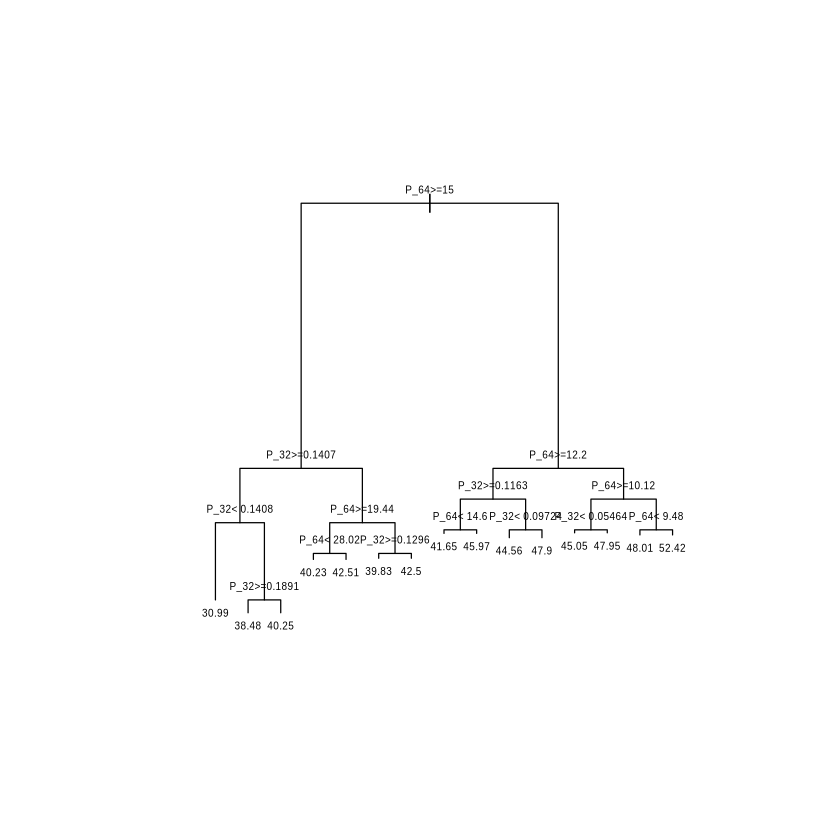

In [7]:
# Question 3c sample code

### Modify this example code to estimate tree using the depth you chose above 
### using the full training data.  Remember to change the predictors!
tree <- rpart(kfr_pooled_pooled_p25 ~ P_32 + P_64, 
                      data=training, 
                      maxdepth = cv_optimal_depth, 
                      cp=0) 


#Visualize the fitted decision tree
plot(tree, margin = 0.2)
text(tree, cex = 0.5)

#Save figure
dev.copy(png,'figure2.png')
dev.off()

In [8]:
# Question 3d sample code 

#Calculate predictions for all rows in training sample
y_train_predictions_tree <- predict(tree, newdata=training)

**Question 3 Answer**

A. As seen in the plot, the out of sample RMSPE goes down with depth upto a certain point, after which the tree starts overfitting and the error for out of sample predictions shoots up again. 
B. Accordingly, the optimal depth is the point with the lowest out of sample RMSPE or 4, as labelled in the graph. 
C. The tree above is created from the full training data. In the first split of the tree, the decision is made based on the value of P_64 (share of 18-64 persons without insurance). Visually, it seems that both P_64 and P_32 are used in roughly the same number of splits. 
D. Code to obtain predictions in training sample above. 

4.  Explain briefly how random forests improve upon decision trees
    using (i) bagging and (ii) input randomization.

In [9]:
# QUESTION 4 Code


**Question 4 Answer**

Bagging, or Bootstrap Aggregating, involves creating multiple decision trees on different subsets of the data (drawn with replacement), and then averaging their predictions. This reduces the variance and avoids overfitting, making the model more generalizable. Input randomization introduces further diversity by selecting a random subset of features for splitting at each node of a tree, thereby increasing the model's ability to capture complex patterns and interactions among features without being overly sensitive to noise. Together, these techniques make random forests a powerful and reliable predictive model.

5. Now implement a random forest with at least 1000 trees (bootstrap
    samples) using the same two predictors you selected for the decision
    tree. Obtain predictions in the training sample.

In [10]:
# QUESTION 5 Code

#-------------------------------------------------------------------------------
# Random Forest using same two predictors as the tree
#-------------------------------------------------------------------------------

#Two R libraries implement random forests: randomForest() and ranger()
#ranger() is quicker, but randomForests() alows nicer importance plots

#Random Forest from 1000 Bootstrapped Samples (ntree=100)
#Random Forests may take a while to run!  Be patient!

## Modify the code to change the predictors that I use to two others 
# (Don't use my predictors! Pick your own!)

smallforest <- randomForest(kfr_pooled_pooled_p25 ~ P_32 + P_64, 
                               ntree=1000, 
                               mtry=2,
                               data=training)

#Tuning parameters are ntree and mtry
#ntree is number of trees in your forest
#mtry is the number of predictors considered at each split (default is number of predictors divided by 3)

smallforest #Review the Random Forest Results

#Generate predictions for training data
y_train_predictions_smallforest <- predict(smallforest, newdata=training, type="response")


Call:
 randomForest(formula = kfr_pooled_pooled_p25 ~ P_32 + P_64, data = training,      ntree = 1000, mtry = 2) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 2

          Mean of squared residuals: 18.50375
                    % Var explained: 30.74

**Question 5 Answer**

Modified code above.

6. Next, implement a random forest with at least 1000 trees (bootstrap
    samples) using the full predictor set (consisting of the 121
    predictors corresponding to variables P_1 through P_121 included in
    the training data). Obtain predictions in the training sample.

In [11]:
# QUESTION 6 Code

#-------------------------------------------------------------------------------
# Random Forest with the full set of predictors
#-------------------------------------------------------------------------------

#Two commands to implement random forests: randomForest() and ranger()
#ranger() is quicker

#Random Forest from 1000 Bootstrapped Samples (ntree=100)
#Random Forests may take a while to run!  Be patient!
mobilityforest <- randomForest(kfr_pooled_pooled_p25 ~ ., 
                               ntree=1000, 
                               mtry=60,
                               importance=TRUE, ## add importance=TRUE so that we store the variable importance information
                               data=training)

#Tuning parameters are ntree and mtry
#ntree is number of trees in your forest
#mtry is the number of predictors considered at each split (default is number of predictors divided by 3)
#Setting mtry<121 can help in small samples like this one.

mobilityforest #Review the Random Forest Results

#Generate predictions for training data
y_train_predictions_forest  <- predict(mobilityforest, newdata=training, type="response")

### Try changing mtry to 20 (16.5% of predictors), 60 (50% of predictors), or 121 (all predictors)



Call:
 randomForest(formula = kfr_pooled_pooled_p25 ~ ., data = training,      ntree = 1000, mtry = 60, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 1000
No. of variables tried at each split: 60

          Mean of squared residuals: 4.747495
                    % Var explained: 82.23

**Question 6 Answer**

Random Forest with mtry = 60 (50% of predictors) shown above. 

7. Random forests typically result in improved accuracy over prediction
    using a single tree. Unfortunately, however, it can be difficult to
    interpret the resulting model. Recall from Lab 6 that one of the
    advantages of decision trees is the attractive and easily
    interpreted diagram that results.

   One can obtain an overall summary of the importance of each predictor in a random forest by measuring how the mean squared error decreases when the predictor is used define tree splits. A large value indicates an important predictor.

   Using the random forest from the previous question, which variables are the most important predictors using this metric? Refer to the data dictionary in [Table 3](#Table3) below to determine what these variables measure.

,%IncMSE,IncNodePurity
P_1,14.996716,197.33550
P_2,11.731866,89.10111
P_3,10.649786,105.86876
P_4,10.871882,106.48611
P_5,11.891062,187.91943
P_6,11.533372,131.07387
P_7,11.937764,161.48765
P_8,15.015651,215.45977
P_9,13.807028,182.19695
P_10,10.129496,110.21672


png 
  3

png 
  2

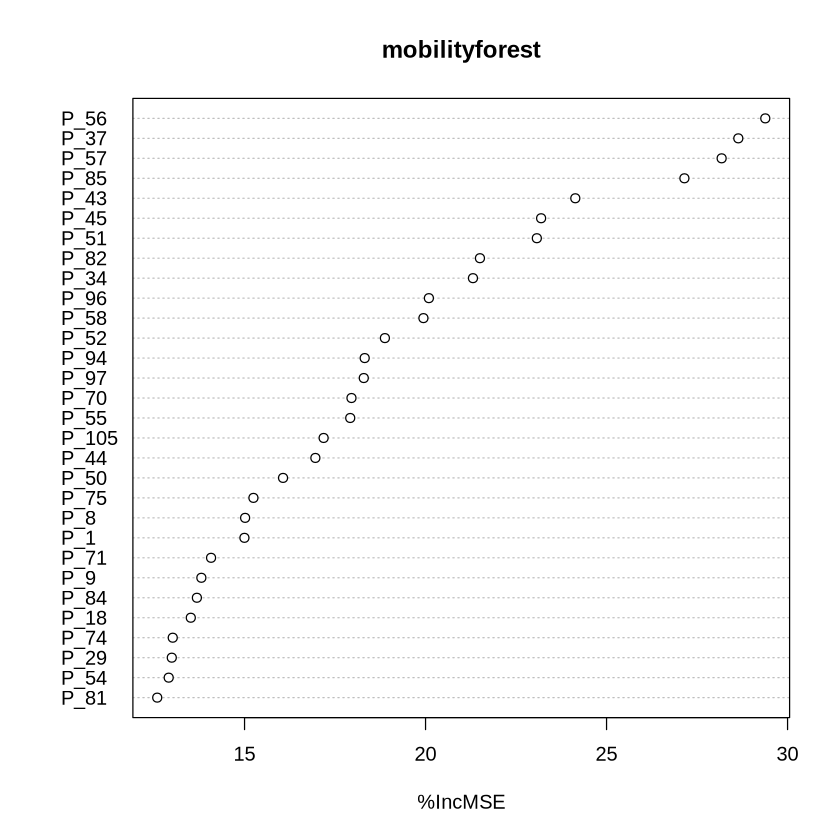

In [12]:
# QUESTION 7 Code

#-------------------------------------------------------------------------------
# What variables are the most important predictors?
#-------------------------------------------------------------------------------

importance(mobilityforest)
varImpPlot(mobilityforest, type=1) #Plot the Random Forest Results

#type	is either 1 or 2, specifying the type of importance measure 
#(1=mean decrease in accuracy, 2=mean decrease in node impurity)

#Save figure
dev.copy(png,'figure3.png')
dev.off()


**Question 7 Answer**

According to this plot, the most important predictors are (in order) P_56, P_37, P_57 and P_85 (followed by a gap). The interpretation of these variables as from the table below is: 

P_56 - Mentally Unhealthy Days per Month (Persons 18 Years and Over)

P_37 - Share black 2000

P_57 - Percent of Adults That Report Fair or Poor Health (Persons 18 Years and Over)

P_85 - % Total: Roman Catholic

8. Calculate and compare the root mean squared prediction error for
    your three models in the **training sample**. Which model does the
    best?

In [13]:
# QUESTION 8 Code

#-------------------------------------------------------------------------------
# Calculate and compare the mean squared error in the training sample. 
#-------------------------------------------------------------------------------

## Root mean squared prediction error in  the training sample.
p <- 3
RMSPE <- matrix(0, p, 1)
RMSPE[1] <- sqrt(mean((training$kfr_pooled_pooled_p25 - y_train_predictions_tree)^2, na.rm=TRUE))
RMSPE[2] <- sqrt(mean((training$kfr_pooled_pooled_p25 - y_train_predictions_smallforest)^2, na.rm=TRUE))
RMSPE[3] <- sqrt(mean((training$kfr_pooled_pooled_p25 - y_train_predictions_forest)^2, na.rm=TRUE))

#Display a table of the results
data.frame(RMSPE, method = c("Tree", "Small RF", "Large RF"))  


RMSPE,method
<dbl>,<chr>
3.9710639,Tree
2.1104591,Small RF
0.8673262,Large RF


**Question 8 Answer**

As seen below, a large RF has the lowest RMSPE and therefore performs the best, with a significant improvement over tree and small RF. 

9. Now turn to the lock box data set **atlas_lockbox.dta**. These data
    contain a variable called **kfr_actual** which is the “truth:” the
    actual value of **kfr_pooled_pooled_p25** for all the counties in
    the sample, including the 50% of the data in the lock box sample.
    Calculate predictions from your models and use **kfr_actual** to
    calculate the root mean squared prediction error for the test
    sample. Which model did the best?

In [14]:
# QUESTION 9 Code

#-------------------------------------------------------------------------------
# Part 6 Calculate and compare the mean squared error in  the lock box data 
#-------------------------------------------------------------------------------

#Read in data with truth. Truth is kfr_actual in these data
download.file("https://raw.githubusercontent.com/ekassos/ec50_s24/main/atlas_lockbox.dta", "atlas_lockbox.dta", mode = "wb")
atlas_test <- read_dta("atlas_lockbox.dta")

#Merge with truth to evaluate predictions. 
atlas <- left_join(atlas_test, atlas_training , by="geoid")

#Separate test data set as a separate data frame
test <- subset(atlas, training==0)

#Get predictions for test data
y_test_predictions_tree <- predict(tree, newdata=test)
y_test_predictions_smallforest <- predict(smallforest, newdata=test, type="response")
y_test_predictions_forest  <- predict(mobilityforest, newdata=test, type="response")

#Calculate RMSPE for test data
p <- 3
OOS_RMSPE <- matrix(0, p, 1)
OOS_RMSPE[1] <- sqrt(mean((test$kfr_actual - y_test_predictions_tree)^2, na.rm=TRUE))
OOS_RMSPE[2] <- sqrt(mean((test$kfr_actual - y_test_predictions_smallforest)^2, na.rm=TRUE))
OOS_RMSPE[3] <- sqrt(mean((test$kfr_actual - y_test_predictions_forest)^2, na.rm=TRUE))

# Display table of results
data.frame(OOS_RMSPE, method = c("Tree", "Small RF", "Large RF"))  


OOS_RMSPE,method
<dbl>,<chr>
4.128169,Tree
4.277144,Small RF
2.209853,Large RF


**Question 9 Answer**

Here as well the large RF has the lowest RMSPE in the out of sample predictions, however the gap is somewhat smaller that in the case of training data. 

10.  Create an annotated/commented do-file, .ipynb Jupyter Notebook, or
    .R file that can replicate all your analyses above. This will be the
    final code that you submit on Gradescope. The motivation for using
    do-files and .R files is described on [page 4](#Dofiles), which has
    been adapted from training materials used by [Innovations for
    Poverty Action (IPA)](https://www.poverty-action.org/) and the
    [Abdul Latif Jameel Poverty Action Lab
    (J-PAL)](https://www.povertyactionlab.org/).


**Final Submission Checklist for Lab 7**

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 49%" />
</colgroup>
<thead>
<tr class="header">
<th><strong>If you’re working with R</strong></th>
<th><strong>If you’re working with Stata</strong></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td><p>Lab 7 Write-Up:</p>
<ul>
<li><p><strong>PDF</strong> of your answers. For graphs, you must save them as images (e.g., .png files) and insert them into the document.</p></li>
</ul>
<p>Lab 7 Code:</p>
<ul>
<li><p><strong>.R script file</strong>, well-annotated replicating all your analyses;<br/><br/>OR</p></li>
<li><p><strong>.ipynb file</strong> and <strong>a .PDF version of this file</strong>.</p></li>
</ul></td>
<td><p>Lab 7 Write-Up:</p>
<ul>
<li><p><strong>PDF</strong> of your answers. For graphs, you must save them as images (e.g., .png files) and insert them into the document.</p></li>
</ul>
<p>Lab 7 Code:</p>
<ul>
<li><p><strong>do-file</strong>, well-annotated replicating all your analyses;<br/><br/>AND</p></li>
<li><p><strong>log-file, not a .smcl file,</strong> with the log showing the output generated by your final do-file.</p></li>
</ul></td>
</tr>
</tbody>
</table>

***If you’re working with an .ipynb notebook***

It is likely that your .ipynb file will be greater than 1 MB in size.
Therefore, for this assignment please submit both your *well-annotated*
**.ipynb file** and **a .PDF version of this file**. The notebook should
replicate all your analyses for Lab 5 (with enough comments that a
principal investigator on a research project would be able to follow and
understand what each step of the code is doing).

## How to submit your assignment

|  |  |
|--|--|
| **Step 1** <br><br> Access the lab assignment under the “Assignments” tab on Canvas| 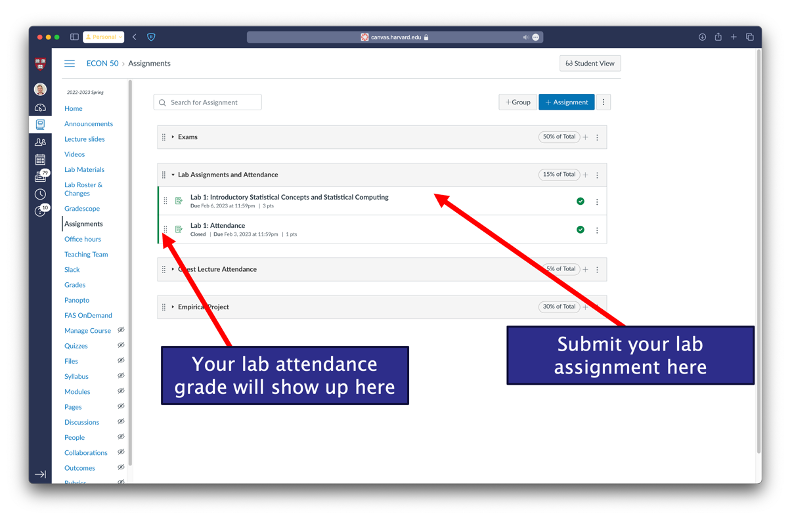 |
| **Step 2** <br><br> Access Gradescope from Canvas| 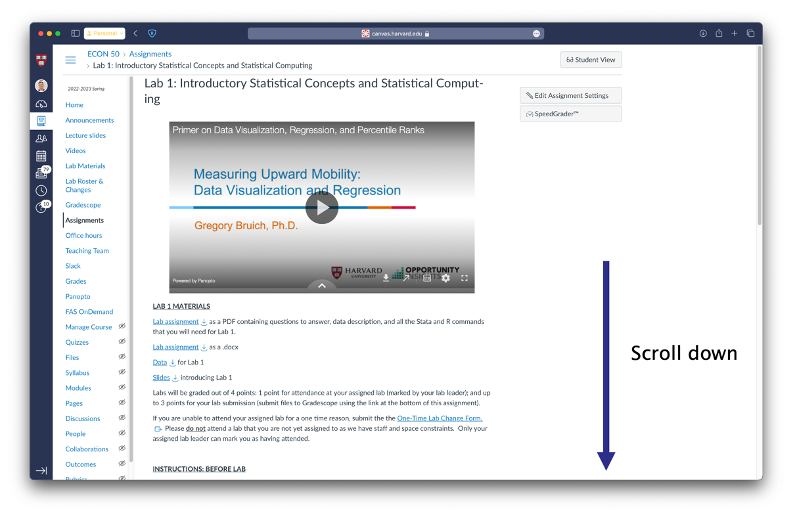 <br> 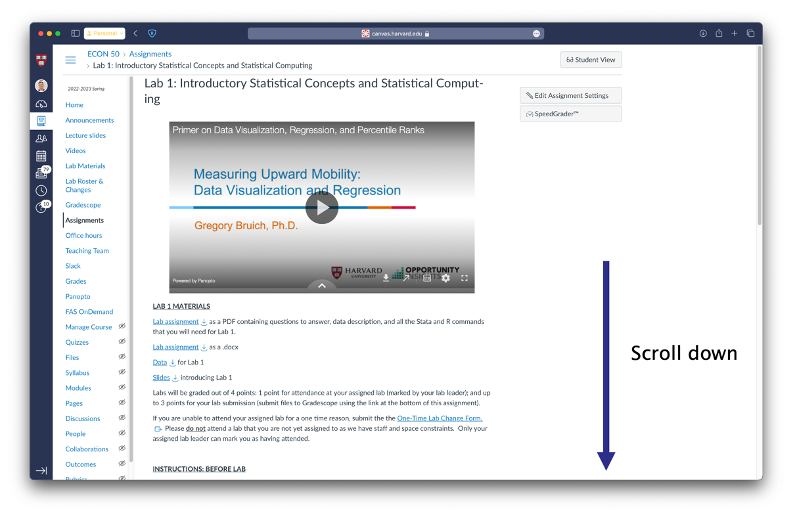|
| **Step 3** <br><br> Access the lab assignment on Gradescope| 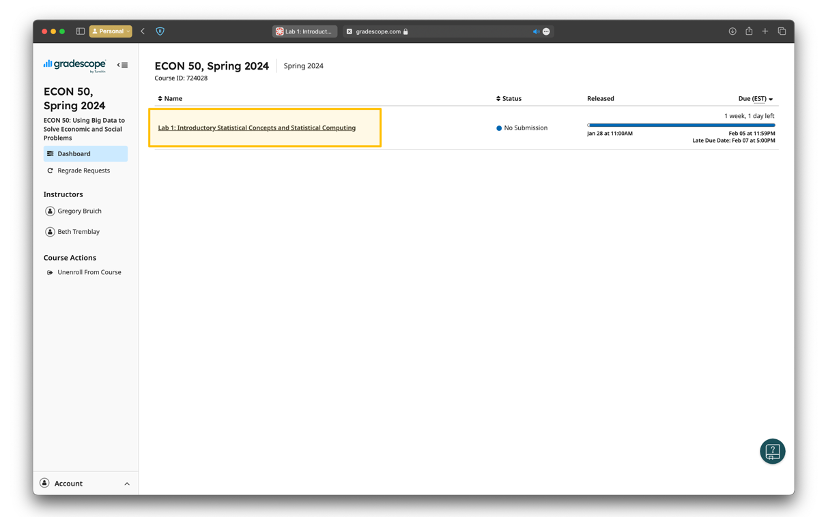 |
| **Step 4** <br><br> Upload your files<br><br> *Check [What files to submit](#What-files-to-submit) to confirm what files you need to submit.*| 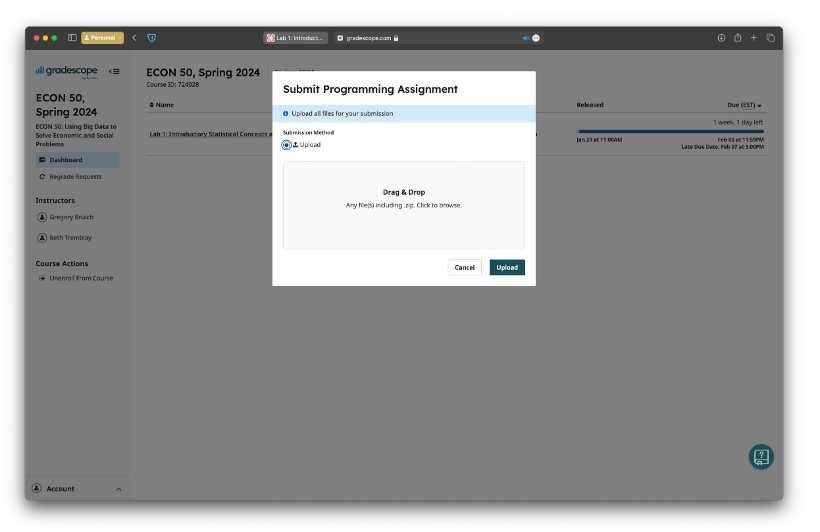 |
| **Step 5** <br><br> What you’ll see after submitting your lab assignment| 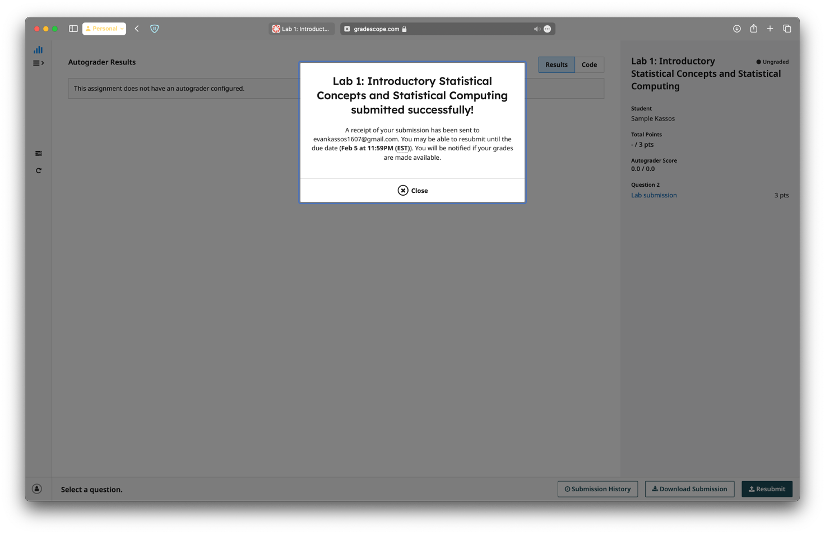 |
| **Step 6** <br><br> Check your submitted files| 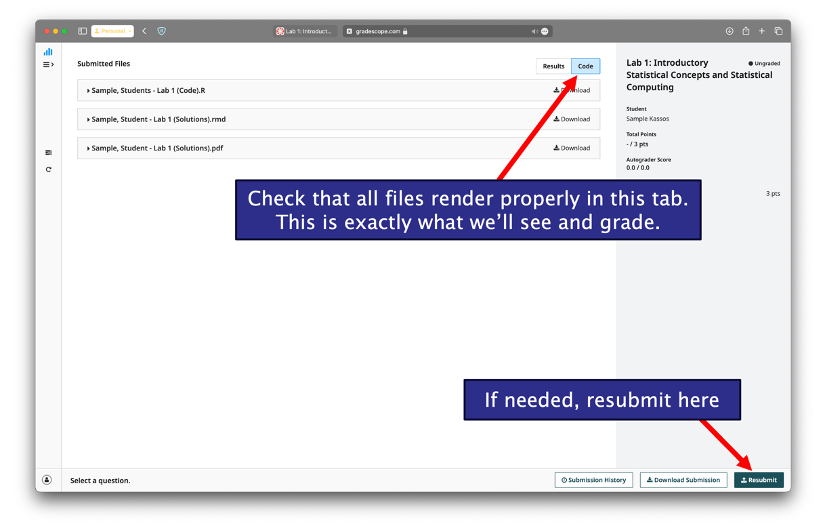 |
| **Step 7** <br><br> You’ll receive an email confirmation as well| 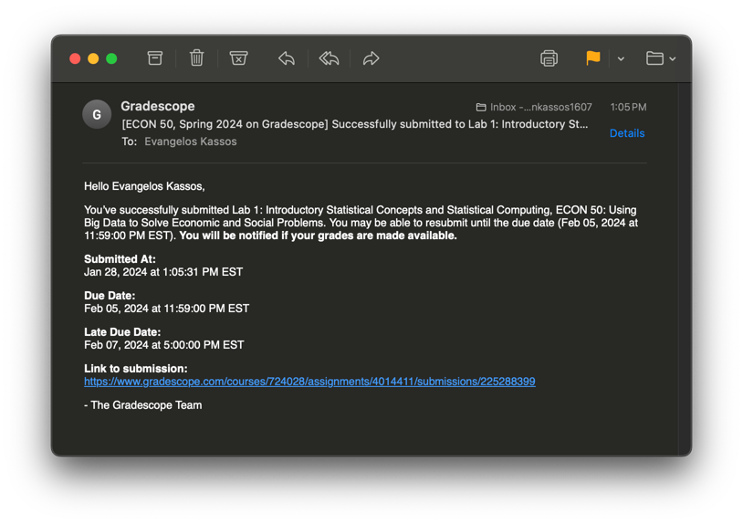 |

## What files to submit

|  |  |
|--|--|
| **If you’re using Python Notebook to write your R code, and a document editor to write your answers** <br><br> 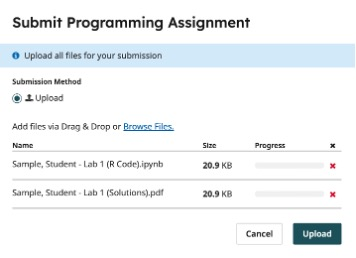| <ul><li>Submit your .ipynb R code file replicating all your analyses above (with enough comments that a principal investigator on a research project would be able to follow and understand what each step of the code is doing). We need your raw code so that we can run your code ourselves if needed.</li><li>Submit your answers as a .pdf file. **Do not submit a .doc/.docx file (Word document)**, as we are unable to read those files on Gradescope.</li></ul><br>_For graphs, always be sure to save them as images (e.g., .png files) and insert them into the answer document even if it was not explicitly asked._<br><br>**Important:** If we do not have both your .ipynb code and .pdf answer files, you will lose 1 out of the 3 lab assignment points.<br><br><span style="color:crimson">**Word of caution:**</span> <u>**Do not**</u> use Python to perform your analysis in this Lab, unless when explicitly instructed. You will receive no points if you’re not using R or Stata for your analysis.|
| **If you’re using a Python Notebook to write your R code AND to write your answers** <br><br> 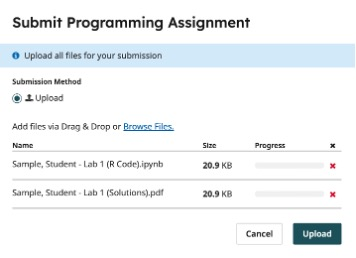| <ul><li>Submit your .ipynb R code file replicating all your analyses above (with enough comments that a principal investigator on a research project would be able to follow and understand what each step of the code is doing). We need your raw code so that we can run your code ourselves if needed.</li><li>Submit the .pdf version of your .ipynb file.</li></ul><br>_For graphs, always be sure to save them as images (either in the cell output or as separate images, such as .png files) and insert them into the answer document even if it was not explicitly asked._<br><br>**Important:** If we do not have both your .ipynb code and .pdf answer files, you will lose 1 out of the 3 lab assignment points.<br><br>**Do not submit ONLY the .ipynb file**, as we might have trouble reading your answers using those files on Gradescope.<br><br><span style="color:crimson">**Word of caution:**</span> <u>**Do not**</u> use Python to perform your analysis in this Lab, unless when explicitly instructed. You will receive no points if you’re not using R or Stata for your analysis.|png)|

## WHAT ARE DO-FILES AND .R FILES AND WHY DO WE NEED ONE?<span id="Dofiles" class="anchor"></span>

*Let’s imagine the following situation - you just found out you have to
present your results to a partner– all the averages you produced and
comparisons you made. Suppose you also found out that the data you had
used to produce all these results was not completely clean, and have
only just fixed it. You now have incorrect numbers and need to re-do
everything.*

*How would you go about it? Would you reproduce everything you did for
Lab 1 from scratch? Can you do it? How long would it take you to do?
Just re-typing all those commands into Stata or R in order and checking
them would take an hour.*

*An important feature of any good research project is that the results
should be reproducible. For Stata and R the easiest way to do this is to
create a text file that lists all your commands in order, so anyone can
re-run all your Stata or R work on a project anytime. Such text files
that are produced within Stata or linked to Stata are called do-files,
because they have an extension .do (like intro_exercise.do). Similarly,
in R, these files are called .R files because they have an extension of
.R. These files feed commands directly into Stata or R without you
having to type or copy them into the command window.*

*An added bonus is that having do-files and .R files makes it very easy
to fix your typos, re-order commands, and create more complicated chains
of commands that wouldn’t work otherwise. You can now quickly reproduce
your work, correct it, adjust it, and build on it.*

*Finally, do-files and .R files make it possible for multiple people to
work on a project, which is necessary for collaborating with others or
when you hand off a project to someone else.*

## DATA DESCRIPTION, FILE: atlas_training.dta \[training data\]

The data consist of all 2,518 counties with at least 10,000 residents
available from the Opportunity Atlas. For *n* = 1,259 counties in the
“test” portion of the data, the outcome variable is set to missing.
These observations are a 50% random sample of all counties with at least
10,000 residents available from the Opportunity Atlas. For more details
on the construction of the variables included in this data set, please
see [<u>Chetty, Raj, John Friedman, Nathaniel Hendren, Maggie R. Jones,
and Sonya R. Porter. 2018. “The Opportunity Atlas: Mapping the Childhood
Roots of Social Mobility.” NBER Working Paper No.
25147</u>](https://opportunityinsights.org/wp-content/uploads/2018/10/atlas_paper.pdf).

**TABLE 1**<span id="Table1" class="anchor"></span>

Training Data

<table>
<colgroup>
<col style="width: 27%" />
<col style="width: 61%" />
<col style="width: 11%" />
</colgroup>
<tbody>
<tr class="odd">
<td><strong>Variable</strong></td>
<td><strong>Definition</strong></td>
<td><strong>Obs.</strong></td>
</tr>
<tr class="even">
<td>(1)</td>
<td>(2)</td>
<td>(3)</td>
</tr>
<tr class="odd">
<td><em>geoid</em></td>
<td>County FIPS code</td>
<td>2,518</td>
</tr>
<tr class="even">
<td><em>pop</em></td>
<td>County Population from DataCommons</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td><em>housing</em></td>
<td>Total number of housing units from Census</td>
<td>2,518</td>
</tr>
<tr class="even">
<td><em>kfr_pooled_pooled_p25</em></td>
<td><p>Statistic 1: Absolute Mobility at the 25th Percentile</p>
<p><strong>(missing for <em>n</em> = 1,259 counties in the test data, non-missing for the other <em>n</em> = 1,259 counties)</strong></p></td>
<td>1,259</td>
</tr>
<tr class="odd">
<td><em>test</em></td>
<td><p>1 = Observation is in test data set (outcome variable is missing)</p>
<p>0 = Observation is in training data (outcome variable is non-missing)</p></td>
<td>2,518</td>
</tr>
<tr class="even">
<td><em>training</em></td>
<td><p>1 = Observation is in training data set (outcome variable is non-missing)</p>
<p>0 = Observation is in the test data (outcome variable is missing)</p></td>
<td>2,518</td>
</tr>
<tr class="odd">
<td><em>P_1</em> through <em>P_121</em></td>
<td>Predictors taken from the Opportunity Insights’ county characteristics file and various other sources</td>
<td>2,518</td>
</tr>
</tbody>
</table>

*Note:* Full list of definitions of *P_1* through *P_121* is in [Table
3](#Table3).

## DATA DESCRIPTION, FILE: atlas_lockbox.dta \[Lock box data\]

The data consist of all 2,518 counties with at least 10,000 residents
available from the Opportunity Atlas. For *n* = 1,259 counties in the
“test” portion of the data, the outcome variable is set to missing.
These observations are a 50% random sample of all counties with at least
10,000 residents available from the Opportunity Atlas. For more details
on the construction of the variables included in this data set, please
see [<u>Chetty, Raj, John Friedman, Nathaniel Hendren, Maggie R. Jones,
and Sonya R. Porter. 2018. “The Opportunity Atlas: Mapping the Childhood
Roots of Social Mobility.” NBER Working Paper No.
25147</u>](https://opportunityinsights.org/wp-content/uploads/2018/10/atlas_paper.pdf).

**TABLE 2**<span id="Table2" class="anchor"></span>

Lock Box Data

|              |                                                                                                |          |
|--------------|------------------------------------------------------------------------------------------------|----------|
| **Variable** | **Definition**                                                                                 | **Obs.** |
| \(1\)        | \(2\)                                                                                          | \(3\)    |
| *kfr_actual* | Actual value for *kfr_pooled_pooled_p25* for all 2,518 counties with at least 10,000 residents | 2,518    |
| *geoid*      | County FIPS code                                                                               | 2,518    |

## DATA DESCRIPTION, FILE: atlas_training.dta \[training data\]

**TABLE 3**<span id="Table3" class="anchor"></span>

Complete List of All Predictor Variables in Training Data

<table>
<colgroup>
<col style="width: 7%" />
<col style="width: 30%" />
<col style="width: 52%" />
<col style="width: 9%" />
</colgroup>
<thead>
<tr class="header">
<th> </th>
<th> </th>
<th> </th>
<th> </th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td></td>
<td>Variable</td>
<td>Description</td>
<td>Obs.</td>
</tr>
<tr class="even">
<td></td>
<td>(1)</td>
<td>(2)</td>
<td>(3)</td>
</tr>
<tr class="even">
<td>1</td>
<td><em>geoid</em></td>
<td>County FIPS code</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>2</td>
<td><em>pop</em></td>
<td>County Population from DataCommons</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>3</td>
<td><em>housing</em></td>
<td>Total number of housing units from Census</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>4</td>
<td><em>kfr_pooled_pooled_p25</em></td>
<td>Statistic 1 Absolute Mobility at the 25th Percentile</td>
<td>1,259</td>
</tr>
<tr class="even">
<td>5</td>
<td><em>test</em></td>
<td><p>1 = Observation is in test data set (outcome variable is missing)</p>
<p>0 = Observation is in training data (outcome variable is non-missing)</p></td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>6</td>
<td><em>training</em></td>
<td><p>1 = Observation is in training data set (outcome variable is non-missing)</p>
<p>0 = Observation is in the test data (outcome variable is missing)</p></td>
<td>2,518</td>
</tr>
<tr class="even">
<td>7</td>
<td><em>P_1</em></td>
<td>Bankruptcies per 1000 adults in 2008</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>8</td>
<td><em>P_2</em></td>
<td>Bankruptcies per 1000 adults in 2009</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>9</td>
<td><em>P_3</em></td>
<td>Bankruptcies per 1000 adults in 2010</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>10</td>
<td><em>P_4</em></td>
<td>Bankruptcies per 1000 adults in 2011</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>11</td>
<td><em>P_5</em></td>
<td>Bankruptcies per 1000 adults in 2012</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>12</td>
<td><em>P_6</em></td>
<td>Bankruptcies per 1000 adults in 2013</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>13</td>
<td><em>P_7</em></td>
<td>Bankruptcies per 1000 adults in 2014</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>14</td>
<td><em>P_8</em></td>
<td>Bankruptcies per 1000 adults in 2015</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>15</td>
<td><em>P_9</em></td>
<td>Bankruptcies per 1000 adults in 2016</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>16</td>
<td><em>P_10</em></td>
<td>% of Individuals Earning &lt; 138% of the FPL without Insurance in 2013</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>17</td>
<td><em>P_11</em></td>
<td>% of Individuals Earning 138%-400% of the FPL without Insurance in 2013</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>18</td>
<td><em>P_12</em></td>
<td>Total Violent and Property Crimes Rate</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>19</td>
<td><em>P_13</em></td>
<td>Total Violent Crimes Rate: Murder Rate</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>20</td>
<td><em>P_14</em></td>
<td>Total Violent Crimes Rate: Rape Rate</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>21</td>
<td><em>P_15</em></td>
<td>Total Violent Crimes Rate: Robbery Rate</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>22</td>
<td><em>P_16</em></td>
<td>Total Violent Crimes Rate: Aggravated Assault Rate</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>23</td>
<td><em>P_17</em></td>
<td>Total Property Crimes Rate</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>24</td>
<td><em>P_18</em></td>
<td>Total Property Crimes Rate: Burglary Rate</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>25</td>
<td><em>P_19</em></td>
<td>Total Property Crimes Rate: Larceny Rate</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>26</td>
<td><em>P_20</em></td>
<td>Total Property Crimes Rate: Motor Vehicle Theft Rate</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>27</td>
<td><em>P_21</em></td>
<td>Total Violent and Property Crime Arrests Rate</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>28</td>
<td><em>P_22</em></td>
<td>Total Violent and Property Crime Arrests Rate: Violent Crime Arrests Rate</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>29</td>
<td><em>P_23</em></td>
<td>Total Violent and Property Crime Arrests Rate: Property Crime Arrests Rate</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>30</td>
<td><em>P_24</em></td>
<td>Mean Household Income 2000</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>31</td>
<td><em>P_25</em></td>
<td>Average Commute Time of Working Adults in 2000</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>32</td>
<td><em>P_26</em></td>
<td>Fraction of Residents w/ a College Degree or More in 2000</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>33</td>
<td><em>P_27</em></td>
<td>Fraction of Residents w/ a College Degree or More in 2006-2010 ACS</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>33</td>
<td><em>P_28</em></td>
<td>Share of Population Born Outside the U.S. in 2006-2010 ACS</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>34</td>
<td><em>P_29</em></td>
<td>Median Household Income in 2016</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>35</td>
<td><em>P_30</em></td>
<td>Median Household Income in 1990</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>36</td>
<td><em>P_31</em></td>
<td>Share Below Poverty Line 2006-2010 ACS</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>37</td>
<td><em>P_32</em></td>
<td>Share Below Poverty Line 2000</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>38</td>
<td><em>P_33</em></td>
<td>Share Below Poverty Line 1990</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>39</td>
<td><em>P_34</em></td>
<td>Share black 2010</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>40</td>
<td><em>P_35</em></td>
<td>Share hisp 2010</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>41</td>
<td><em>P_36</em></td>
<td>Share asian 2010</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>42</td>
<td><em>P_37</em></td>
<td>Share black 2000</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>43</td>
<td><em>P_38</em></td>
<td>Share white 2000</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>44</td>
<td><em>P_39</em></td>
<td>Share hisp 2000</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>45</td>
<td><em>P_40</em></td>
<td>Share asian 2000</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>46</td>
<td><em>P_41</em></td>
<td>Average School District Level Standardized Test Scores in 3rd Grade in 2013</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>47</td>
<td><em>P_42</em></td>
<td>Average Rent for Two-Bedroom Apartment in 2015</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>48</td>
<td><em>P_43</em></td>
<td>Share of Single-Headed Households with Children 2006-2010 ACS</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>49</td>
<td><em>P_44</em></td>
<td>Share of Single-Headed Households with Children 1990</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>50</td>
<td><em>P_45</em></td>
<td>Share of Single-Headed Households with Children 2000</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>51</td>
<td><em>P_46</em></td>
<td>Share of Working Adults w/ Commute Time of 15 Minutes Or Less in 2006-2010 ACS</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>52</td>
<td><em>P_47</em></td>
<td>Employment Rate 2000</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>53</td>
<td><em>P_48</em></td>
<td>Census Form Rate Return Rate 2010</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>54</td>
<td><em>P_49</em></td>
<td>Log wage growth for HS Grad., 2005-2014</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>55</td>
<td><em>P_50</em></td>
<td>Share of People who are not white 2010</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>56</td>
<td><em>P_51</em></td>
<td>Population Density (per square mile) in 2010</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>57</td>
<td><em>P_52</em></td>
<td>Population Density (per square mile) in 2000</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>58</td>
<td><em>P_53</em></td>
<td>Average Annual Job Growth Rate 2004-2013</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>59</td>
<td><em>P_54</em></td>
<td>Job Density (in square miles) in 2013</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>60</td>
<td><em>P_55</em></td>
<td>Physically Unhealthy Days per Month (Persons 18 Years and Over)</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>61</td>
<td><em>P_56</em></td>
<td>Mentally Unhealthy Days per Month (Persons 18 Years and Over)</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>62</td>
<td><em>P_57</em></td>
<td>Percent of Adults That Report Fair or Poor Health (Persons 18 Years and Over)</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>63</td>
<td><em>P_58</em></td>
<td>Percent of Low Birthweight Births (&lt;2.5kg)</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>64</td>
<td><em>P_59</em></td>
<td>Primary Care Physicians (PCP) Rate per 100,000 Population</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>65</td>
<td><em>P_60</em></td>
<td>Mental Health Providers (MHP) Rate per 100,000 Population</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>66</td>
<td><em>P_61</em></td>
<td>Dentists Rate per 100,000 Population</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>67</td>
<td><em>P_62</em></td>
<td>Health Care Costs Price-adjusted Medicare Reimbursements</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>68</td>
<td><em>P_63</em></td>
<td>Percent of Persons Without Insurance (Population Under 19 Years, 2013 est.)</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>69</td>
<td><em>P_64</em></td>
<td>Percent of Persons Without Insurance (Population 18 to 64 Years, 2013 est.)</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>70</td>
<td><em>P_65</em></td>
<td>Percent of Persons Without Insurance (Population Under 65 Years, 2013 est.)</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>71</td>
<td><em>P_66</em></td>
<td>Premature Age-adjusted Mortality Rate per 100,000 Population</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>72</td>
<td><em>P_67</em></td>
<td>Drug Poisoning Mortality Rate per 100,000 Population</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>73</td>
<td><em>P_68</em></td>
<td>Percent Diabetics (Adults)</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>74</td>
<td><em>P_69</em></td>
<td>Percent of Diabetic Medicare Enrollees Receiving Hba1c Test</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>75</td>
<td><em>P_70</em></td>
<td>Diabetic Medicare Enrollees (Out of Total Medicare Enrolles)</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>76</td>
<td><em>P_71</em></td>
<td>Teen Births Rate per 100,000 Population (Females 15 to 19 Years)</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>77</td>
<td><em>P_72</em></td>
<td>Chlamydia Cases Rate per 100,000 Population</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>78</td>
<td><em>P_73</em></td>
<td>HIV Prevalence Rate per 100,000 Population</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>79</td>
<td><em>P_74</em></td>
<td>Percent Current Smokers (Persons 18 Years and Over)</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>80</td>
<td><em>P_75</em></td>
<td>Percent Drinking Adults (Persons 18 Years and Over)</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>81</td>
<td><em>P_76</em></td>
<td>Percent of Persons with Limited Access to Healthy Foods</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>82</td>
<td><em>P_77</em></td>
<td>Percent of Persons with Access to Exercise Opportunities</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>83</td>
<td><em>P_78</em></td>
<td>Percent Obese Persons (20 Years and Over)</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>84</td>
<td><em>P_79</em></td>
<td>Percent Percent Physically Inactive Persons (20 Years and Over)</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>85</td>
<td><em>P_80</em></td>
<td>Percent of Children Eligible for Free Lunch (Persons &lt; 18 Years)</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>86</td>
<td><em>P_81</em></td>
<td>Food Environment Index</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>87</td>
<td><em>P_82</em></td>
<td>% Total: Evangelical Protestant</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>88</td>
<td><em>P_83</em></td>
<td>% Total: Mainline Protestant</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>89</td>
<td><em>P_84</em></td>
<td>% Total: Historically Black Protestant</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>90</td>
<td><em>P_85</em></td>
<td>% Total: Roman Catholic</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>91</td>
<td><em>P_86</em></td>
<td>% Total: Jewish Congregations</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>92</td>
<td><em>P_87</em></td>
<td>% Total: Latter-day Saint (Mormon)</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>93</td>
<td><em>P_88</em></td>
<td>% Total: Islamic</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>94</td>
<td><em>P_89</em></td>
<td>% Total: Hindu</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>95</td>
<td><em>P_90</em></td>
<td>% Total: Buddhist</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>96</td>
<td><em>P_91</em></td>
<td>% Total: Orthodox Christian</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>97</td>
<td><em>P_92</em></td>
<td>% Total: Jehovah's Witnesses</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>98</td>
<td><em>P_93</em></td>
<td>% Total: Other</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>99</td>
<td><em>P_94</em></td>
<td>% Total: Evangelical Protestant Member Count</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>100</td>
<td><em>P_95</em></td>
<td>% Total: Mainline Protestant Member Count</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>101</td>
<td><em>P_96</em></td>
<td>% Total: Historically Black Protestant Member Count</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>102</td>
<td><em>P_97</em></td>
<td>% Total: Roman Catholic Member Count</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>103</td>
<td><em>P_98</em></td>
<td>% Total: Jewish Member Count</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>104</td>
<td><em>P_99</em></td>
<td>% Total: Latter-day Saint (Mormon) Member Count</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>105</td>
<td><em>P_100</em></td>
<td>% Total: Islamic Member Count</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>106</td>
<td><em>P_101</em></td>
<td>% Total: Hindu Member Count</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>107</td>
<td><em>P_102</em></td>
<td>% Total: Buddhist Member Count</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>108</td>
<td><em>P_103</em></td>
<td>% Total: Orthodox Christian Member Count</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>109</td>
<td><em>P_104</em></td>
<td>% Total: Jehovah's Witnesses Member Count</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>110</td>
<td><em>P_105</em></td>
<td>% Total: Other Member Count</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>111</td>
<td><em>P_106</em></td>
<td>% Total Evangelical Protestant: Advent Christian Church</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>112</td>
<td><em>P_107</em></td>
<td>% Total Evangelical Protestant: Adventists - Other</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>113</td>
<td><em>P_108</em></td>
<td>% Total Evangelical Protestant: Church of God General Conference</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>114</td>
<td><em>P_109</em></td>
<td>% Total Evangelical Protestant: Seventh Day Adventists</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>115</td>
<td><em>P_110</em></td>
<td>% Total Evangelical Protestant: Seventh Day Church of God</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>116</td>
<td><em>P_111</em></td>
<td>% Total Evangelical Protestant: American Baptist Association</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>117</td>
<td><em>P_112</em></td>
<td>% Total Evangelical Protestant: Baptist General Conference</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>118</td>
<td><em>P_113</em></td>
<td>% Total Evangelical Protestant: Baptist - Other</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>119</td>
<td><em>P_114</em></td>
<td>% Total Evangelical Protestant: Baptist Bible Fellowship</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>120</td>
<td><em>P_115</em></td>
<td>% Total Evangelical Protestant: Baptist Missionary Association of America</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>121</td>
<td><em>P_116</em></td>
<td>% Total Evangelical Protestant: Cooperative Baptist Fellowship</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>122</td>
<td><em>P_117</em></td>
<td>% Total Evangelical Protestant: Independent Baptist Churches</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>123</td>
<td><em>P_118</em></td>
<td>% Total Evangelical Protestant: Conservative Baptist Association</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>124</td>
<td><em>P_119</em></td>
<td>% Total Evangelical Protestant: Free Will Baptists</td>
<td>2,518</td>
</tr>
<tr class="odd">
<td>125</td>
<td><em>P_120</em></td>
<td>% Total Evangelical Protestant: General Assoc. of Regular Baptists</td>
<td>2,518</td>
</tr>
<tr class="even">
<td>126</td>
<td><em>P_121</em></td>
<td>% Total Evangelical Protestant: Assoc. of General Baptists</td>
<td>2,518</td>
</tr>
</tbody>
</table>